# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


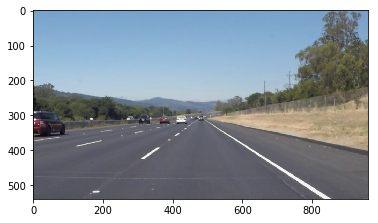

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [18]:
def read_image_set(fldr):
    """
    'fldr' is a string containing the test images folder
    the return is a list of multidimensional arrays
    """   
    return [mpimg.imread(fldr+img) for img in os.listdir(fldr)]
    
def show_image_list(imgList,title=None):
    """ 
    show_image_list(imgList):
    Generate image subplot for visualization of 'imgList' as a grid of subplots
    --------------------------------------------------------------------------------------------
    INPUT:
        imgList: A list of multidimensional arrays containing the images
        title : String containing title of superplot
    OUTPUT:
        none
    ============================================================================================
    """
    gridSize = [2,int(len(imgList)/2)] 
    fig = plt.figure()
    for indx, img in enumerate(imgList):
        fig.add_subplot(gridSize[0],gridSize[1],indx+1)
        if len(img.shape)==3:
            imgplot = plt.imshow(img)
        else:
            imgplot = plt.imshow(img,cmap='gray')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.001)
    fig.suptitle(title)  
    plt.rcParams["figure.figsize"] = [16,9]
    plt.show()
    return fig
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_canny(img, sigma=0.33):
    """
    auto_canny(imgList):
    Computes the upper and lower threshold parameters using the median of the 
    pixel intensities for the computation of the Canny transform
    Note: Code adapted from
    https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    --------------------------------------------------------------------------------------------
    INPUT:
        img: image to apply the canny transform
        sigma : constant parameter for variation and tunning of the threshold percertanges
    OUTPUT:
        edgeImg: single channel image with canny transform
    ============================================================================================
    """
    # Compute the median of the pixel intensities
    m = np.median(img)
    
    # Compute the upper and lower limits for canny parameters using median
    low_threshold = int(max(0, (1.0 - sigma) * m))
    high_threshold = int(max(0, (1.0 + sigma) * m))
    
    return cv2.Canny(img, low_threshold, high_threshold)
    
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once 
    you want to average/extrapolate the line segments you detect to map out the 
    full extent of the lane (going from the result shown in 
    raw-lines-example.mp4 to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Extrapolate the lines
    left,right = fit_line(lines,img.shape)
        
    # Compute line extreme points    
    lane_lines = np.vstack((line_computation(img,left),\
                             line_computation(img,right)))
    
    # Draw Lines
    for x1,y1,x2,y2 in lane_lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), \
                        minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)

    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    ---------------------------------------------------------------------------
    INPUT:
        img: output of the hough_lines(), An image with lines drawn on it.
                Should be a blank image (all black) with lines drawn on it.
        initial_img: image before any processing 
    OUTPUT:
        none
    ===========================================================================
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def line_computation(img,coef):
    """
    line_computation(img,coef)
    Computes the extreme points of the lane lines based on the image
    coefficients
    ---------------------------------------------------------------------------
    INPUT:
        img: image 
        coef : line coefficients [[m,b]]
    OUTPUT:
        line_pts = Line points [x1,y1,x2,y2]
    ===========================================================================
    """

    # Define Line points [x1,y1,x2,y2]
    line_pts = np.zeros([1,4], dtype=np.int)
    
    # Line equation y = mx+b-->x = (y-b)/m
    line_pts[0][1] = img.shape[0]
    line_pts[0][0] = int((line_pts[0][1]-coef[1])/coef[0])
    line_pts[0][3] = img.shape[0]*0.62
    line_pts[0][2] = int((line_pts[0][3]-coef[1])/coef[0])
    
    return line_pts

def separate_lines(lines,imshape):
    """
    separate_lines(lines)
    Classifies left and right lines  based on slope
    ---------------------------------------------------------------------------
    INPUT:
        lines: line points [[x1,y1,x2,y2]]
    OUTPUT:
        right{}: right line dictionary with the following structure 
            ['slope'] = line slope  (y2-y1)/(x2-x1)
            ['lane']  = [[x1,y1,x2,y2]] 
        left{}:
            ['slope'] = line slope  (y2-y1)/(x2-x1)
            ['lane']  = [[x1,y1,x2,y2]] 
    ===========================================================================
    """
    # Generate a structure of data for left and right lines
    left = {'slope':[],'intercept':[],'lane':np.empty((0,4),dtype=np.int32)}
    
    right = {'slope':[],'intercept':[],'lane':np.empty((0,4),dtype=np.int32)}
    
    # Compute Lines and Separate right and left lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Skip vertical line iteration
            if x1==x2 or y1==y2:
                continue       
            m = (y2-y1)/(x2-x1)
            b = y2 - m*x2
            if m < 0 and x2 < imshape[1]/2:
                left['slope'].append(m) 
                left['intercept'].append(b) 
                left['lane'] = np.append(left['lane'],line,axis= 0)
                
            elif m > 0 and x2> imshape[1]/2:
                right['slope'].append(m) 
                right['intercept'].append(b) 
                right['lane'] =np.append(right['lane'],line,axis= 0)
                
    return left,right

def  outlier_rejection(slope,intercept, lane, std = 1.5):
    """
    outlier_rejection(slope, lane, std)
    Extract outliers based on the standard deviation of the slopes and 
    intercepts
    ---------------------------------------------------------------------------
    INPUT:
        slope: line slope list
        lane : line points [[x1,y1,x2,y2]]
        std : standard deviation threshold
    OUTPUT:
        pts: points [[x,y]] with inliers
    ===========================================================================
    """
    # Compute Inliers index
    indx = (np.abs(slope-np.array(slope).mean())<std*np.array(slope).std()) & \
            (np.abs(intercept-np.array(intercept).mean())<\
             std*np.array(intercept).std())
            
    n = len(np.array(slope)[indx]) # Array Size
    # Extract inliers using index and form points array [[x,y]]
    pts = np.hstack((lane[indx][:,[0,2]].reshape((n*2,1)),\
                    lane[indx][:,[1,3]].reshape((n*2,1))))    
    return pts
    
def fit_line(lines,imshape):
    """
    fit_line(lines)
    Extrapolates lines using linear regression with Hueber Loss distance for 
    the left and right lines
    ---------------------------------------------------------------------------
    INPUT:
        line: line points [[x1,y1,x2,y2]]
    OUTPUT:
        right['coef']: right line coefficients [[m,b]] where m is the slope and
                        b is the line intercept
        left['coef']: right line coefficients [[m,b]] where m is the slope and
                        b is the line intercept
    ===========================================================================
    """
    # Classify left and right lines based on slope
    left,right =  separate_lines(lines,imshape)              
    
    # Discard outliers based on the slope and intercept 
    # standard deviation (Mean + 2*SD)
    left['points']  = outlier_rejection(left['slope'],left['intercept'], \
        left['lane'],1.5)
    right['points'] = outlier_rejection(right['slope'],right['intercept'],\
         right['lane'],1.5)
    
    # Linear Regression on the inliers points using Huber Loss as error 
    # distance DIST_HUBER
    # LEFT:
    l = cv2.fitLine(left['points'], cv2.DIST_HUBER, 0,0.01,0.01)
    m = l[1]/l[0]       # Slope
    b = l[3]-(l[2]*m)   # Intercept
    left['coef'] = [m,b]
    
    #RIGHT:  
    r = cv2.fitLine(right['points'], cv2.DIST_HUBER, 0,0.01,0.01)
    m = r[1]/r[0]       # Slope
    b = r[3]-(r[2]*m)   # Intercept
    right['coef'] = [m,b]

    return left['coef'],right['coef']


def mask_color_lanes(img):
    """
    mask_color_lanes(img)
    Applies a color based mask to an rgb image by converting it to an HSV color
    image
    ---------------------------------------------------------------------------
    INPUT:
        img: RGB color image
    OUTPUT:
        maskedImg: Single Channel Masked image
    ===========================================================================
    """
    hlsImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Define Upper and Lower Thresholds for white and yellow lanes
    white = {'low':np.uint8([  0, 220,   0]),'up':np.uint8([255, 255, 255])}
    yellow = {'low':np.uint8([0, 0, 150]),'up':np.uint8([80, 255, 255])}
    
    # Apply a mask by filtering colors that are in range
    white_mask = cv2.inRange(hlsImg, white['low'], white['up'])  
    yellow_mask = cv2.inRange(hlsImg,  yellow['low'], yellow['up'])
    
    # Combine masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    # Apply mask to image
    maskedImg = cv2.bitwise_and(img, img, mask=mask)
    
    return maskedImg


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

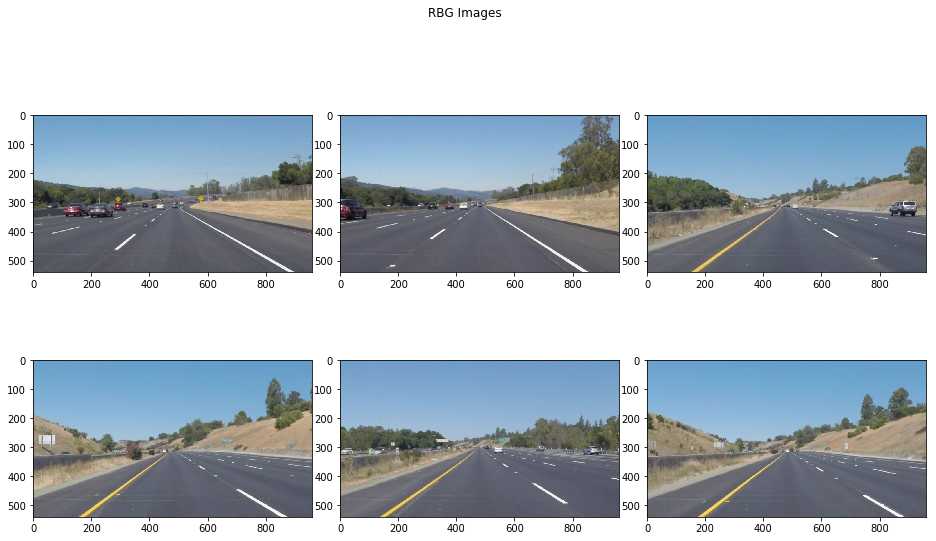

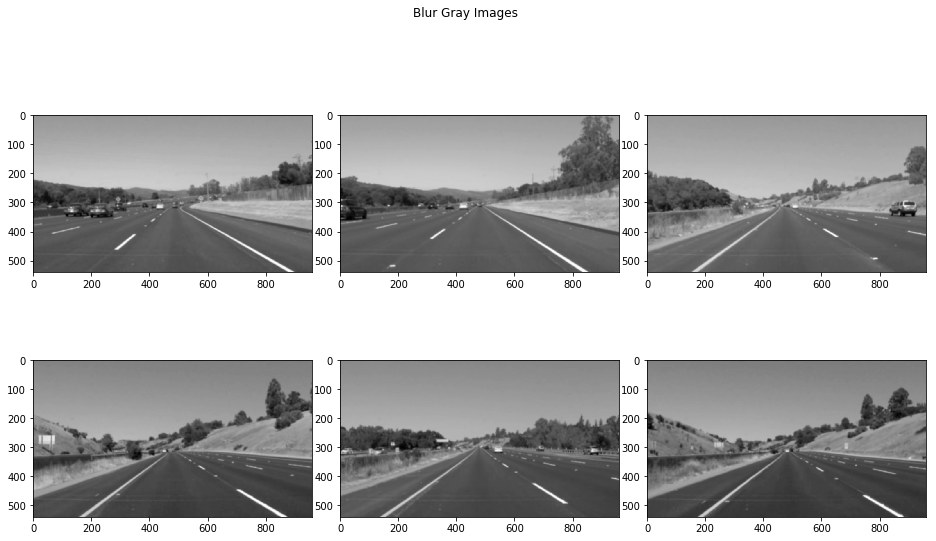

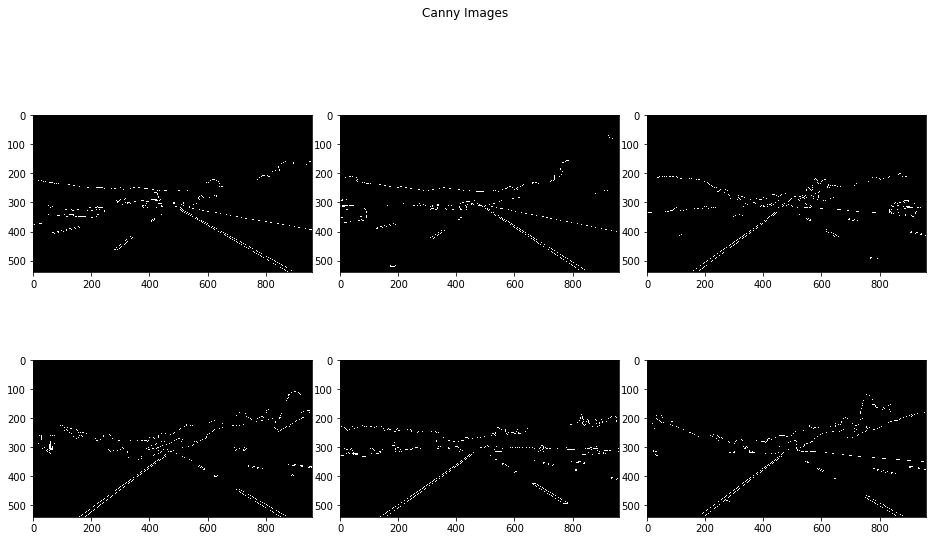

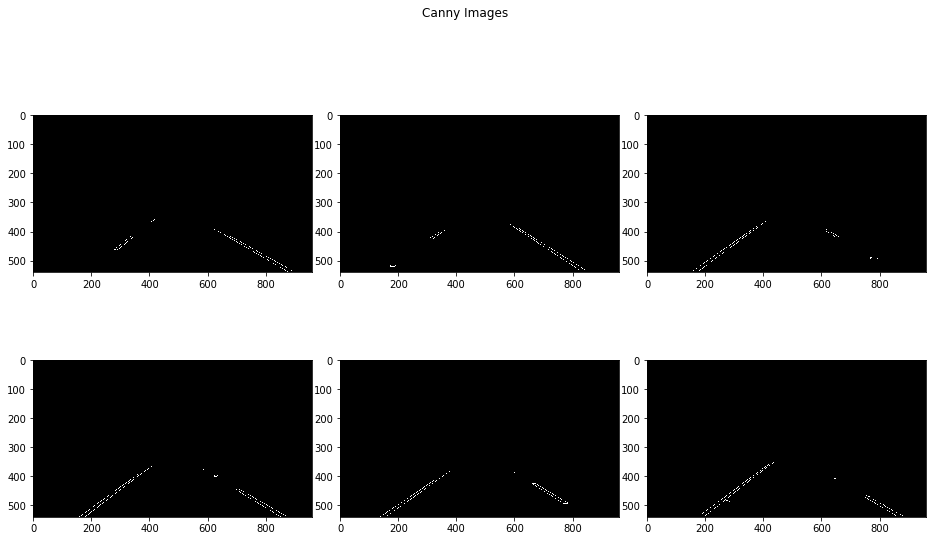

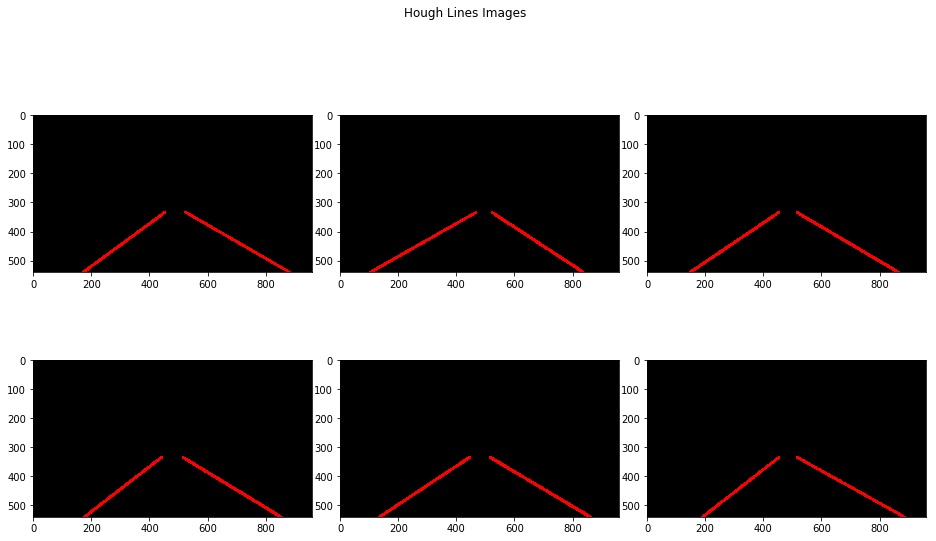

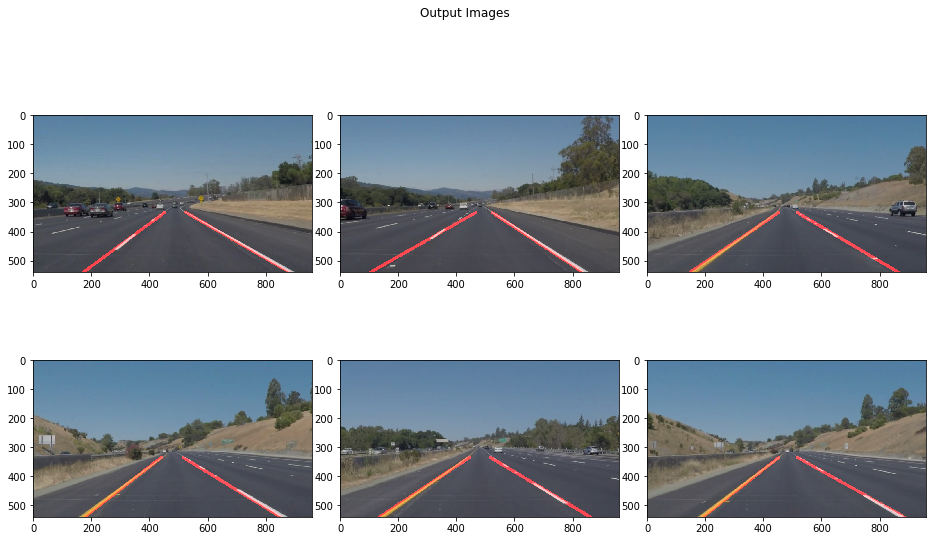

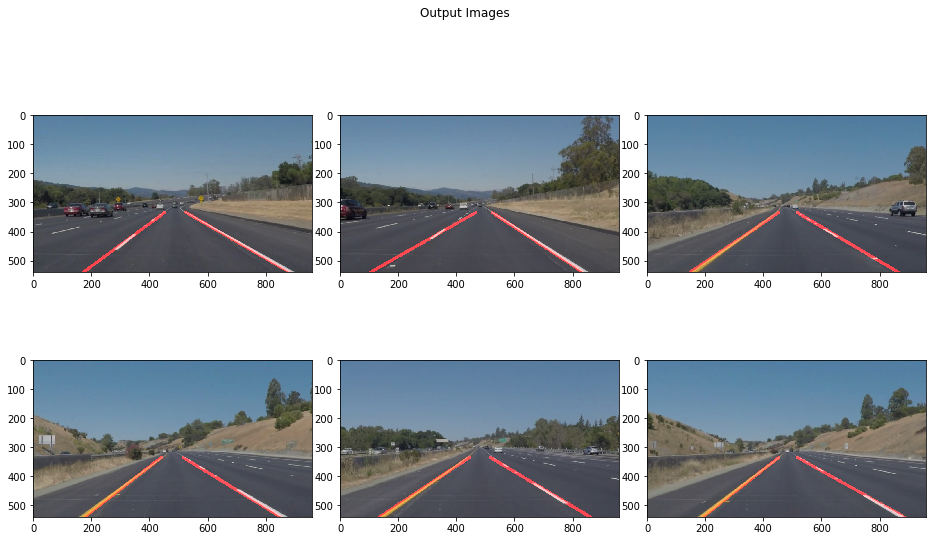

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Import Images
rgbImgs = read_image_set("test_images/") # RGB images
fig = show_image_list(rgbImgs,'RBG Images')    
fig.savefig('test_images_output/RGB.png')
# Convert Images into Greyscale
greyImgs = list(map(lambda img: grayscale(img) , rgbImgs))
#show_image_list(greyImgs,'Greyscale Images')
# Filter Image using Gaussian Smoothing
blur_grayImgs = list(map(lambda img: gaussian_blur(img,kernel_size=9), greyImgs ))
show_image_list(blur_grayImgs,'Blur Gray Images')
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
cannyImgs = list(map(lambda img: canny(img,low_threshold,high_threshold), 
                         blur_grayImgs))
show_image_list(cannyImgs,'Canny Images')
# Apply Mask
imshape = rgbImgs[0].shape
vertices = np.array([[(100,imshape[0]),(imshape[1]*.45, imshape[0]*0.65), 
                          (imshape[1]*.55, imshape[0]*0.65), (imshape[1],imshape[0])]], 
                            dtype=np.int32)

masked_edgesImgs = list(map(lambda img: region_of_interest(img,vertices), cannyImgs))
show_image_list(masked_edgesImgs,'Canny Images')

 
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
hough_linesImgs = list(map(lambda img: hough_lines(img, rho, theta, 
                                                   threshold, min_line_len, max_line_gap),
                                                    masked_edgesImgs))

show_image_list(hough_linesImgs,'Hough Lines Images')
outputImgs = list(map(lambda img, init_img: weighted_img(img,init_img) ,hough_linesImgs,rgbImgs))
show_image_list(outputImgs,'Output Images')



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def line_smoothing (l_coef,r_coef):
    """
    line_smoothing(line_coeff)
    Computes the mean of the previous lane line coefficients to smooth the 
    visualization of the global lane
    ---------------------------------------------------------------------------
    INPUT:
        r_coef: right line coefficients [[m,b]] where m is the slope and
                        b is the line intercept
        l_coef: right line coefficients [[m,b]] where m is the slope and
                        b is the line intercept
    OUTPUT:
        avg_lineCoeff: Average line coefficients
    ===========================================================================
    """
    global global_lanes
    l_coef = np.array(l_coef).T
    r_coef = np.array(r_coef).T
    # Use fifo on the first 5 lines
    if global_lanes.shape[0] >= 10:
        global_lanes = np.delete(global_lanes,0,0)
    # Append line coefficient
    global_lanes = np.append(global_lanes,np.hstack((l_coef,r_coef)),axis=0)
    
    avg_lineCoef = global_lanes.mean(axis=0)    
    return avg_lineCoef[0:2],avg_lineCoef[2:]

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once 
    you want to average/extrapolate the line segments you detect to map out the 
    full extent of the lane (going from the result shown in 
    raw-lines-example.mp4 to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Extrapolate the lines
    left,right = fit_line(lines,img.shape)
    
    # Smooth ouput Coefficients
    l_coef,r_coef = line_smoothing (left,right)
    
    # Compute line extreme points    
    lane_lines = np.vstack((line_computation(img,l_coef),\
                             line_computation(img,r_coef)))
    
    # Draw Lines
    for x1,y1,x2,y2 in lane_lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), \
                        minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
def process_image(img):
    # Apply Mask on colors
    colorMaskImg = mask_color_lanes(img)
    # Convert Images into Greyscale
    grayImg = grayscale(colorMaskImg)
    # Filter Image using Gaussian Smoothing
    blur_grayImg = gaussian_blur(grayImg,kernel_size=9)
    # Apply an automatic parameter canny detection
    cannyImg = auto_canny(blur_grayImg)
    
    # Apply Mask
    imshape = img.shape
    vertices = np.array([[(100,imshape[0]),(imshape[1]*.45, imshape[0]*0.62), 
                              (imshape[1]*.55, imshape[0]*0.62), (imshape[1],imshape[0])]], 
                                dtype=np.int32)
    maskedImg = region_of_interest(cannyImg,vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    hough_linesImg = hough_lines(maskedImg, rho, theta,threshold, min_line_len, max_line_gap)
    result = weighted_img(hough_linesImg,img) 

    return result    

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Initialize GLobal Array for Smoothing
global_lanes = np.empty((0,4)) 
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()
white_clip.reader.close()
white_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 42.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.58 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
global_lanes = np.empty((0,4)) 
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()
yellow_clip.reader.close()
yellow_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:16<00:00, 41.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 16.7 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
global_lanes = np.empty((0,4)) 
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
clip3.reader.close()
clip3.audio.reader.close_proc()
challenge_clip.reader.close()
challenge_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:11<00:00, 22.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 12.1 s


In [12]:
clip3.reader.close()
clip3.audio.reader.close_proc()
challenge_clip.reader.close()
challenge_clip.audio.reader.close_proc()

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))